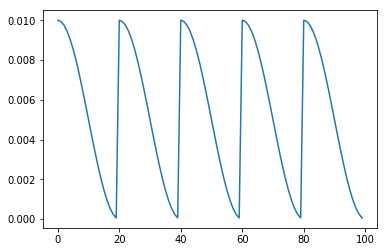

In [1]:
# example of a cosine annealing learning rate schedule
from matplotlib import pyplot
from math import pi
from math import cos
from math import floor

# cosine annealing learning rate schedule
def cosine_annealing(epoch, n_epochs, n_cycles, lrate_max):
	epochs_per_cycle = floor(n_epochs/n_cycles)
	cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
	return lrate_max/2 * (cos(cos_inner) + 1)

# create learning rate series
n_epochs = 100
n_cycles = 5
lrate_max = 0.01
series = [cosine_annealing(i, n_epochs, n_cycles, lrate_max) for i in range(n_epochs)]
# plot series
pyplot.plot(series)
pyplot.show()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train: 0.840, Test: 0.807


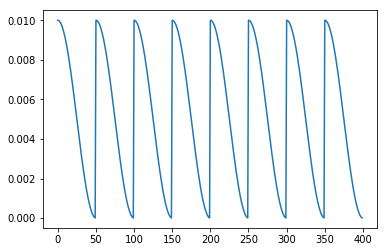

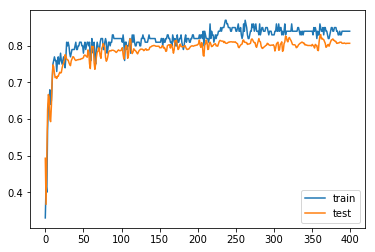

In [2]:
# mlp with cosine annealing learning rate schedule on blobs problem
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor
from matplotlib import pyplot

# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()

	# calculate learning rate for an epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)

	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs=None):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# define learning rate callback
n_epochs = 400
n_cycles = n_epochs / 50
ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.01)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0, callbacks=[ca])
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot learning rate
pyplot.plot(ca.lrates)
pyplot.show()
# learning curves of model accuracy
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [3]:
# example of saving models for a snapshot ensemble
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor

# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()

	# calculate learning rate for epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)

	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs={}):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)

	# save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		# check if we can save model
		epochs_per_cycle = floor(self.epochs / self.cycles)
		if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
			# save model to file
			filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
			self.model.save(filename)
			print('>saved snapshot %s, epoch %d' % (filename, epoch))

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# create snapshot ensemble callback
n_epochs = 500
n_cycles = n_epochs / 50
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)
# fit model
model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0, callbacks=[ca])

>saved snapshot snapshot_model_1.h5, epoch 49
>saved snapshot snapshot_model_2.h5, epoch 99
>saved snapshot snapshot_model_3.h5, epoch 149
>saved snapshot snapshot_model_4.h5, epoch 199
>saved snapshot snapshot_model_5.h5, epoch 249
>saved snapshot snapshot_model_6.h5, epoch 299
>saved snapshot snapshot_model_7.h5, epoch 349
>saved snapshot snapshot_model_8.h5, epoch 399
>saved snapshot snapshot_model_9.h5, epoch 449
>saved snapshot snapshot_model_10.h5, epoch 499


(100, 2) (1000, 2)
>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5
>loaded snapshot_model_4.h5
>loaded snapshot_model_5.h5
>loaded snapshot_model_6.h5
>loaded snapshot_model_7.h5
>loaded snapshot_model_8.h5
>loaded snapshot_model_9.h5
>loaded snapshot_model_10.h5
Loaded 10 models
> 1: single=0.812, ensemble=0.812
> 2: single=0.817, ensemble=0.814
> 3: single=0.808, ensemble=0.811
> 4: single=0.811, ensemble=0.808
> 5: single=0.819, ensemble=0.814
> 6: single=0.813, ensemble=0.812
> 7: single=0.809, ensemble=0.810
> 8: single=0.800, ensemble=0.810
> 9: single=0.807, ensemble=0.812
> 10: single=0.760, ensemble=0.813
Accuracy 0.806 (0.016)


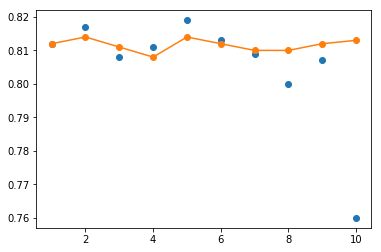

In [4]:
# load models and make a snapshot ensemble prediction
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'snapshot_model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load models in order
members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()